In [1]:
import torch
from dataset import load_dataset
from basic_unet import UNet
import matplotlib.pyplot as plt
from rise import RISE
from pathlib import Path
from plot_utils import plot_image_row
from skimage.feature import canny

In [2]:
batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size)
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [3]:
sample = next(iter(test_loader))

segment = sample['segment']
segment = segment.squeeze()

image = sample['input'].to(device)
output = model(image)
output = output.detach().cpu().squeeze().numpy()
output = (output > output.mean())

In [4]:
class SegmentationRISE(RISE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        mask_count = self.N
        _, _, H, W = x.size()

        # generate new images by putting mask on top of original image
        stack = torch.mul(self.masks, x.data)

        output = model(x).squeeze()
        output = (output > output.mean())

        pixels = []
        for x in range(output.shape[0]):
            for y in range(output.shape[1]):
                if output[x][y]:
                    pixels.append((x, y))

        pixels_per_batch = 1000
        saliencies = []
        for i in range(0, len(pixels), pixels_per_batch):
            current_pixels = pixels[i:i+pixels_per_batch]

            # run generated images through the model
            p = []
            for i in range(0, mask_count, self.gpu_batch):
                output_mask = self.model(stack[i:min(i + self.gpu_batch, mask_count)])
                pixel_classes = []
                for x, y in current_pixels:
                    pixel_classes.append(output_mask[0][x][y])
                p.append(torch.tensor([pixel_classes]))
            p = torch.cat(p)
            p = p.to(device)

            # Number of classes
            CL = p.size(1)

            sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(mask_count, H * W))

            sal = sal.view((CL, H, W))
            sal /= mask_count
            saliencies.append(sal)
        return saliencies


masks_path = Path('rise_masks.npy')
explainer = SegmentationRISE(model, (240, 240), batch_size)
if not masks_path.exists():
    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=masks_path)
else:
    explainer.load_masks(masks_path)

saliencies = None
with torch.set_grad_enabled(False):
    saliencies = explainer(image)

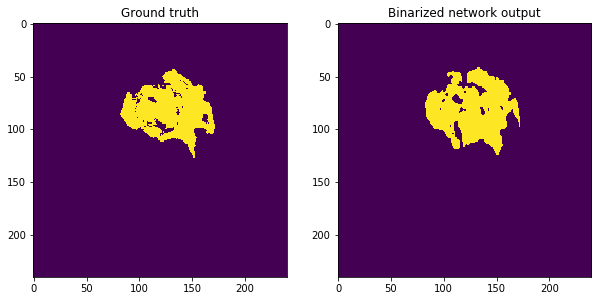

Saliency map, Saliency map overlayed on binarized network output (max)


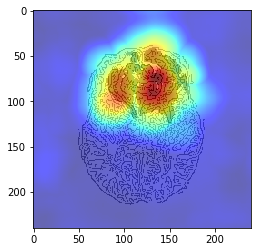

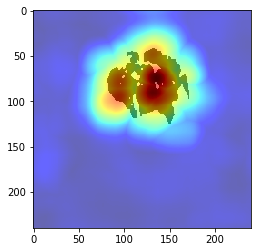

Saliency map, Saliency map overlayed on binarized network output (mean)


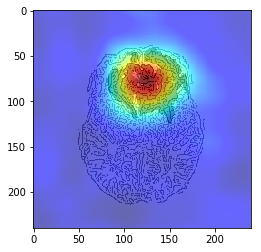

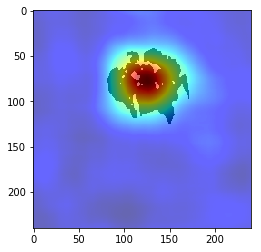

In [5]:
plot_image_row([segment, output], labels=['Ground truth', 'Binarized network output'])

print('Saliency map, Saliency map overlayed on binarized network output (max)')

merged = torch.cat(saliencies)
maxed = torch.max(merged, dim=0)[0]

plt.imshow(output, cmap='gray_r')
edges = canny(image.cpu().numpy()[0][1], sigma=0.01)
plt.imshow(edges, alpha=0.5, cmap='gray_r')
plt.imshow(maxed.cpu(), cmap='jet', alpha=0.6)
plt.show()

plt.imshow(output, cmap='gray_r')
plt.imshow(maxed.cpu(), cmap='jet', alpha=0.6)
plt.show()

print('Saliency map, Saliency map overlayed on binarized network output (mean)')
mean = torch.mean(merged, dim=0)
plt.imshow(output, cmap='gray_r')
plt.imshow(edges, alpha=0.5, cmap='gray_r')
plt.imshow(mean.cpu(), cmap='jet', alpha=0.6)
plt.show()

plt.imshow(output, cmap='gray_r')
plt.imshow(mean.cpu(), cmap='jet', alpha=0.6)
plt.show()